<a href="https://colab.research.google.com/github/alecbidaran/Chest-CTs-image-segmentation-with-UNET/blob/main/medical_segmentation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install jupyter-dash

     |████████████████████████████████| 9.6 MB 7.6 MB/s 
     |████████████████████████████████| 357 kB 50.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=17b98e3fc738904558ef17c385181fa81949c288b1e57780b5cf299857de2b88
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans
!unzip covid19-ct-scans.zip
!rm covid19-ct-scans.zip

401 - Unauthorized
unzip:  cannot find or open covid19-ct-scans.zip, covid19-ct-scans.zip.zip or covid19-ct-scans.zip.ZIP.
rm: cannot remove 'covid19-ct-scans.zip': No such file or directory


In [ ]:
!pip install -q torch_snippets pytorch_model_summary

     |████████████████████████████████| 43 kB 819 kB/s 
     |████████████████████████████████| 213 kB 8.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 10.1 MB 43.8 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 


In [ ]:
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2 
import numpy as np 
import pandas as pd 
import nibabel as nib


In [ ]:
def read_ct(path):
  image=nib.load(path)
  array=image.get_fdata()
  array=np.rot90(np.array(array,dtype=np.float32))
  return array

In [ ]:
pd.read_csv("metadata.csv").sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
17,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/lung_mask/radiopaedi...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
8,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
6,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [ ]:
CT_scans=Glob("ct_scans/")
Mask_scan=Glob("infection_mask/")

2021-11-15 08:45:31.020 | INFO     | torch_snippets.paths:inner:24 - 20 files found at ct_scans/
2021-11-15 08:45:31.025 | INFO     | torch_snippets.paths:inner:24 - 20 files found at infection_mask/


(512, 512, 270)
(630, 630, 42)


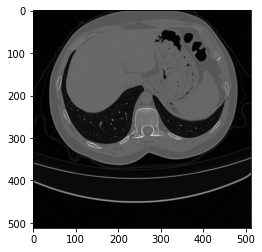

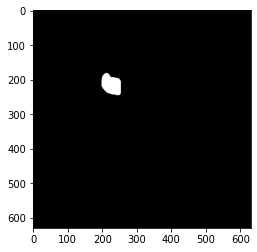

In [ ]:
img=read_ct(CT_scans[10])
mask=read_ct(Mask_scan[10])
print(img.shape)
print(mask.shape)
plt.imshow(img[...,20],cmap='gray')
plt.figure()
plt.imshow(mask[...,20],cmap='gray')

In [ ]:
CT = []
Mask = []
img_size = 224




for case in range(10): #Concat all cases to list
    ct = read_ct(CT_scans[case])
    mask = read_ct(Mask_scan[case])
    
    for imgsize in range(35):        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[...,imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[np.newaxis,...])
        Mask.append(mask_img[np.newaxis,...])

In [ ]:
CT=np.array(CT)
Mask=np.array(Mask)
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

In [ ]:
class CT_dataset(Dataset):
    def __init__(self, CT,Mask):
        self.ct_scans =CT
        self.mask_scan = Mask

    def __len__(self):
        return len(self.ct_scans)

    def __getitem__(self, idx):
        ct=self.ct_scans[idx]
        masks=self.mask_scan[idx]
        return ct,masks
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([torch.tensor(im.copy()[None]) for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.tensor(mask.copy()[None]) for mask in masks]).float().to(device)
        return ims, ce_masks

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(norm_data,Mask,test_size=0.1,random_state=42)

In [ ]:
train_dataset=CT_dataset(x_train,y_train)
test_dataset=CT_dataset(x_test,y_test)

In [ ]:
train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True,collate_fn=train_dataset.collate_fn)
valid_dl=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False,collate_fn=test_dataset.collate_fn)


(200, 1, 224, 224)
(200, 224, 224)


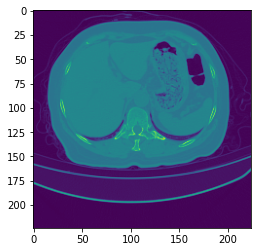

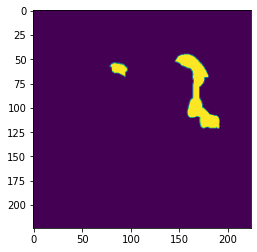

In [ ]:
image,label=train_dataset[:200]
print(image.shape)
print(label.shape)
plt.imshow(image[160].squeeze(0))
plt.figure()
plt.imshow(label[160])

In [ ]:
len(train_dataset)

315

In [ ]:
from torch import nn 
import torchvision
import torch.nn.functional as F

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3),padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def dilate_conv(in_channels, out_channels,dilation):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1,dilation=dilation),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class tinyUNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=1):
        super().__init__()
        self.block1=conv(1,64)
        self.block2=conv(64,64)
        self.block3=conv(64,128)
        self.block4=conv(128,128)
        self.block5=conv(128,256)
        self.block6=conv(256,256)
        self.block7=conv(256,512)
        self.block8=conv(512,512)
        self.block9=conv(512,1024)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256+256,256)
        self.up_conv8 = up_conv(128+128, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 +64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)
        
        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x = self.sigmoid(self.conv11(x1))

        return x

In [ ]:
def dice_coeff(preds,targets):
  smooth=0.001
  preds=preds.flatten()
  targets=targets.flatten()
  intersection=(preds*targets).sum().float()
  dice=(2*intersection+smooth)/(preds.sum()+targets.sum()+smooth)
  return dice
ce = nn.BCELoss()
def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  #dice=dice_coeff(preds,targets)
  loss=ce_loss+1-dice
  acc=dice
  return loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks,masks)
    return loss.item(), acc.item()

In [ ]:
model =tinyUNet().to(device)
criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [ ]:
from torchsummary import summary
summary(model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.782	trn_acc: 0.969	val_loss: 0.662	val_acc: 0.994	(44.35s - 842.58s remaining)
EPOCH: 2.000	trn_loss: 0.601	trn_acc: 0.994	val_loss: 0.582	val_acc: 0.994	(88.41s - 795.70s remaining)
EPOCH: 3.000	trn_loss: 0.572	trn_acc: 0.994	val_loss: 0.568	val_acc: 0.994	(131.96s - 747.79s remaining)
EPOCH: 4.000	trn_loss: 0.565	trn_acc: 0.994	val_loss: 0.563	val_acc: 0.994	(175.56s - 702.26s remaining)
EPOCH: 5.000	trn_loss: 0.562	trn_acc: 0.994	val_loss: 0.561	val_acc: 0.994	(219.53s - 658.59s remaining)
EPOCH: 6.000	trn_loss: 0.561	trn_acc: 0.994	val_loss: 0.560	val_acc: 0.994	(263.45s - 614.71s remaining)
EPOCH: 7.000	trn_loss: 0.560	trn_acc: 0.994	val_loss: 0.560	val_acc: 0.994	(306.96s - 570.08s remaining)
EPOCH: 8.000	trn_loss: 0.559	trn_acc: 0.994	val_loss: 0.559	val_acc: 0.994	(350.61s - 525.91s remaining)
EPOCH: 9.000	trn_loss: 0.559	trn_acc: 0.994	val_loss: 0.559	val_acc: 0.994	(394.58s - 482.26s remaining)
EPOCH: 10.000	trn_loss: 0.559	trn_acc: 0.993	val_loss: 0.

In [ ]:
valid_dl=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn=test_dataset.collate_fn)


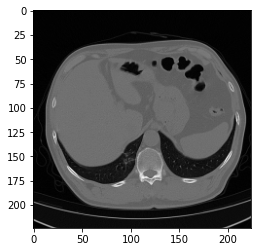

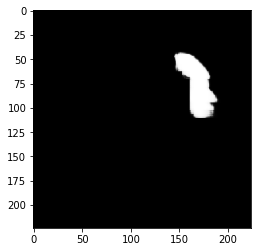

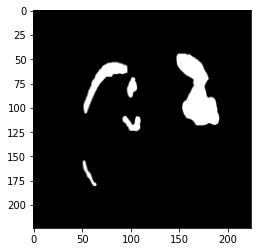

In [ ]:
img,mask=next(iter(valid_dl))
pimg=img[0].squeeze(0).detach().cpu().numpy()
_mask=model(img)
plt.imshow(pimg,cmap="gray")
plt.figure()

plt.imshow(_mask[0].squeeze(0).cpu().detach().numpy(),cmap="gray")
plt.figure()

plt.imshow(mask[0].squeeze(0).cpu().detach().numpy(),cmap="gray")



/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:468: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


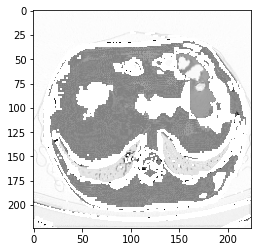

In [ ]:
augment_image=cv2.bitwise_or(cv2.bitwise_not(_mask[0].squeeze(0).cpu().detach().numpy()),np.float32(pimg))
plt.imshow(augment_image,cmap="gray")